In [ ]:
using LinearAlgebra, ProgressMeter, Random, StaticArrays, Distributions, StatsBase, Hungarian, Dates

using GLMakie, CairoMakie
gl(args...; kwargs...) = GLMakie.activate!(args...; kwargs...);
cairo(args...; kwargs...) = CairoMakie.activate!(args...; kwargs...);
set_theme!(resolution = (1000,800), fontsize=20);
set_window_config!(float=false);
ProgressMeter.ijulia_behavior(:clear);

using CUDA
import NPhotons as nph
include("utils.jl");

Here we demonstrate our software using to simple examples. First, we determine a single fictional test structure using two hierarchical stages, and then a  weighted ensemble of three structures. Please note that due to julia's just-in-time compilation, the first execution of each cell can take a bit of time. 

# Single Structure

In [6]:
# Create the test reference structure

ps = SVector{3, Float64}[
    [-6.88, 1.7, 1.73], 
    [-4.57, -0.81, -0.35], 
    [-1.91, -3.26, -2.05], 
    [1.35, -4.12, -4.2], 
    [3.24, -5.69, -1.05], 
    [4.31, -1.89, -1.69], 
    [3.23, 1.95, -1.43], 
    [-0.38, 3.18, -0.23], 
    [-0.85, 4.52, 3.51], 
    [2.45, 4.42, 5.77]
] # positions of the Gaussians

object = 0.01nph.AtomVolume(ps, 1.0, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


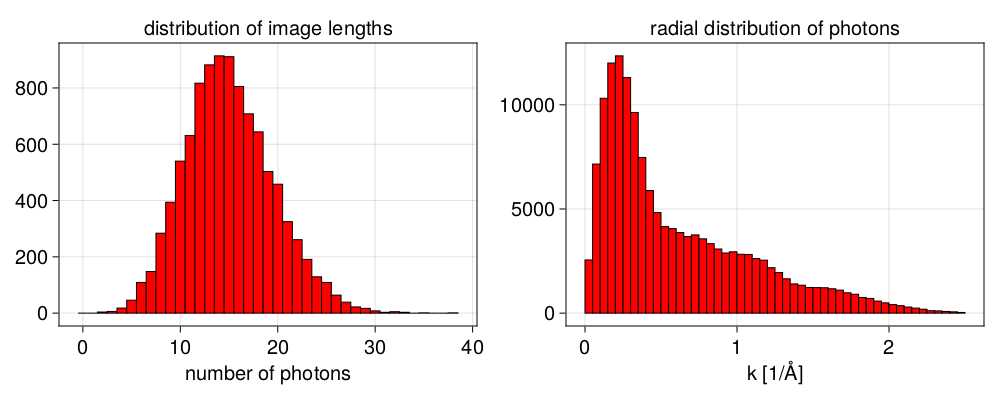

In [7]:
# Generate images

# set the beam intensity such that on average 15 photons are scattered per image
λ = 2.5
N = round(Int, 15 / nph.scatteringProbability(object, λ = λ)) 


radius = 2.5
images = nph.generateImages(10000, N, object, wavelength = λ, maxr = radius) # generate 10000 images


cairo(); fig = Figure(resolution = (1000, 400)); 
ax1 = Axis(fig[1,1], xlabel = "number of photons", title = "distribution of image lengths", titlefont = :regular); 
hist!(ax1, length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)
ax2 = Axis(fig[1,2], xlabel = "k [1/Å]", title = "radial distribution of photons", titlefont = :regular)
hist!(ax2, norm.(reduce(vcat, images)), bins=0:0.05:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

## Stage 1

In [8]:
# Setup computation on gpu. For the first stage, the images are modified to solve the structure at reduced resolution

σ = 1.0
params = nph.integrationParameters(qstep = 0.05, qmax = radius, wavelength = λ, precision = 23, npercircle = 32)
logp = nph.logpClosureConf(nph.smoothenImages(images, σ), params, N);

In [16]:
# Setup Monte Carlo simulated annealing

objectEnergy = -logp(nph.smoothen(object, σ)) # reference value

proposers = (nph.AdaptiveProposer(nph.CombinedProposer(
    nph.StructureProposer(nph.AtomVolume(1, 2.5)), 
    nph.WidthProposer(0.01)
)), )

stage1 = nph.Annealer(0.01nph.randomAtomVolume(5, 2.0, 5), proposers, temperature = 1e3, thalf = 1e2);

In [17]:
# Open a for realtime visualization during the computation. 
# If this does not work, it can be disabled by removing the argument "output = output_func()" in the next cell
# Note the pseudologarithmic scaling on the y-axis

gl()
fig, onode, snode = monitor(nph.smoothen(object, σ), stage1, aligndt = Second(5), sortdt = Day(100));

function output_func()
    dt = Millisecond(30)
    t = now() - dt + Second(1)
    function output(state)
        if now() - t > dt
            snode[] = state
            t = now()
        end
        return !ispressed(fig, Keyboard.escape)
    end
end

display(fig); focus()

In [18]:
# Run simulated annealing. Expected runtime 1 minute (strongly hardware dependent)

targetTemp = 1e-1
nsteps = nph.remainingSteps(stage1, targetTemp = targetTemp)
nph.anneal!(stage1, x -> -logp(x) - objectEnergy, output = output_func(), nsteps = nsteps, minTemp = targetTemp);

Progress: 100%|███████████████████████████| Time: 0:00:09 ( 7.19 ms/it)
  stepsizes:    [0.0083]
  temperature:  0.1
  nsteps:       1329/1329
  accepted:     [0.13]
  energy:       741.8577554593794


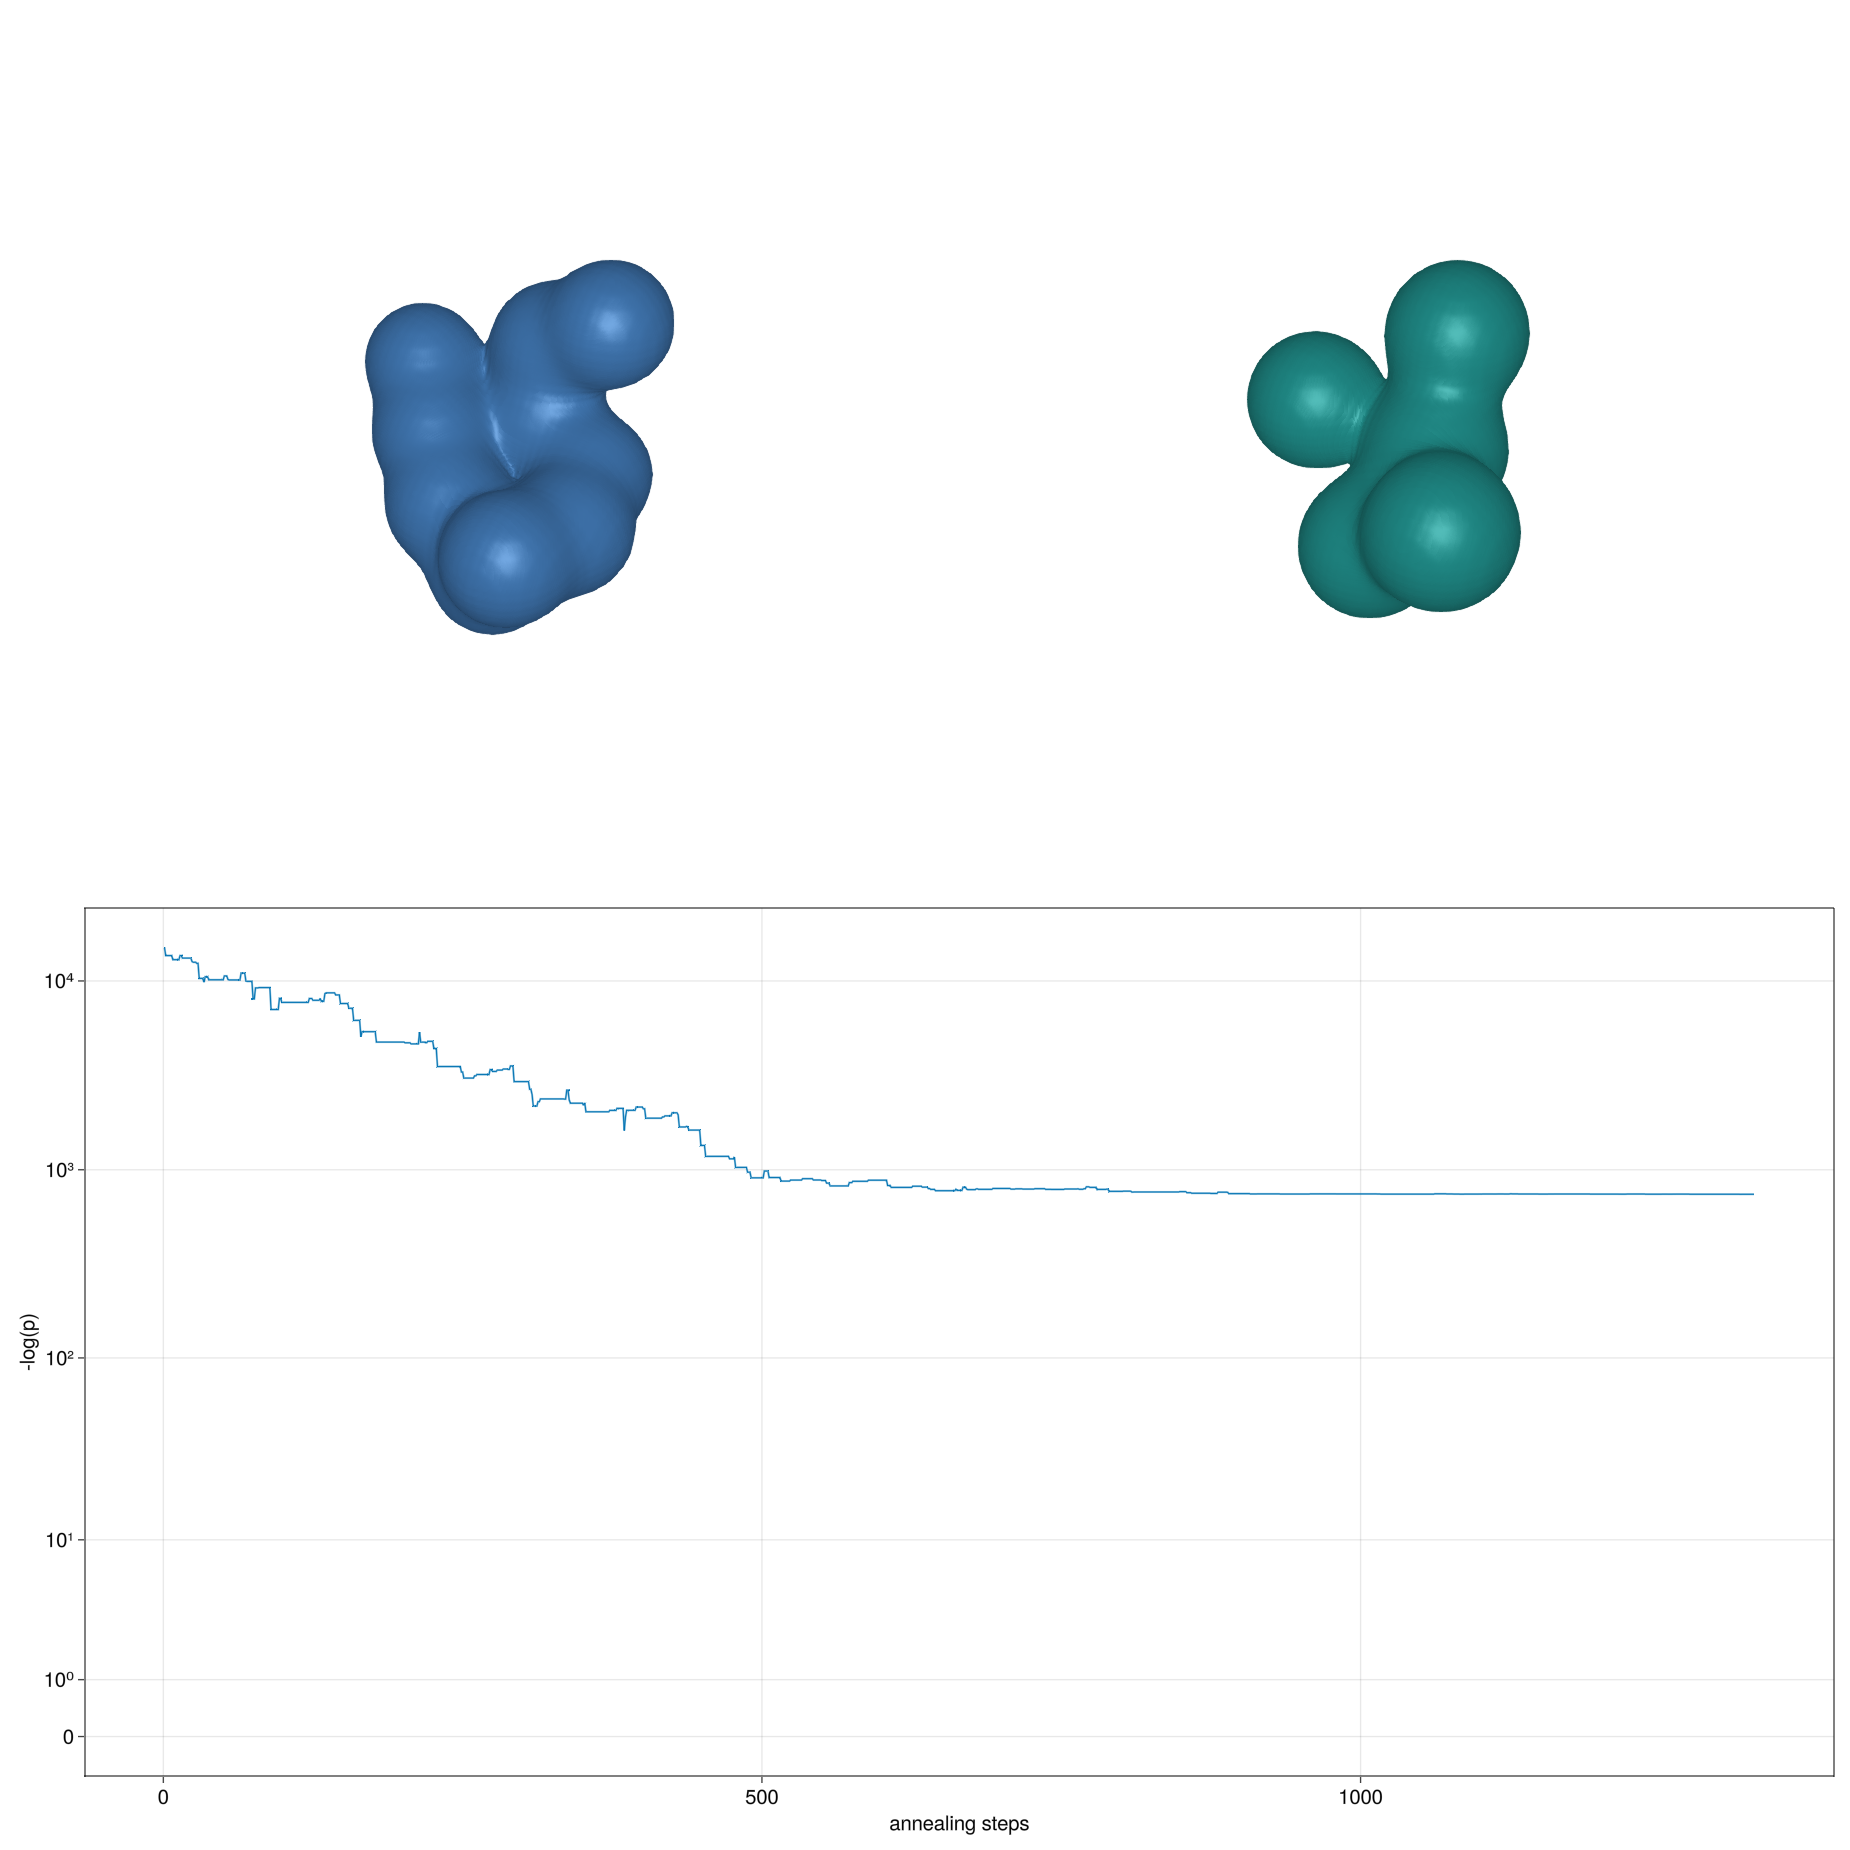

In [19]:
# the output should now look something like this
fig

## Stage 2

In [20]:
# Setup computation on gpu

params = nph.integrationParameters(qstep = 0.05, qmax = radius, wavelength = λ, precision = 23, npercircle = 32)
logp = nph.logpClosureConf(images, params, N);

In [26]:
# Setup Monte Carlo simulated annealing

objectEnergy = -logp(object)

proposers = (nph.AdaptiveProposer(nph.CombinedProposer(
    nph.StructureProposer(stage1.configuration), # This is where the result from the previous stage is used
    nph.WidthProposer(0.001)
)), )

stage2 = nph.Annealer(0.01nph.randomAtomVolume(10, 1.0, 10), proposers, temperature = 1e3, thalf = 5e3);

In [27]:
# Open a window for realtime visualization during the computation. 
# If this does not work, it can be disabled by removing the argument "output = output_func()" in the next cell

gl()
fig, onode, snode = monitor(object, stage2, aligndt = Second(5), sortdt = Day(100));

function output_func()
    dt = Millisecond(30)
    t = now() - dt + Second(1)
    function output(state)
        if now() - t > dt
            snode[] = state
            t = now()
        end
        return !ispressed(fig, Keyboard.escape)
    end
end

display(fig); focus()

In [28]:
# Run simulated annealing. 
# This will take a while and progress will not be visible immediately.
# Expected runtime 10 minutes (strongly hardware dependent).

targetTemp = 1.0
nsteps = nph.remainingSteps(stage2, targetTemp = targetTemp) + 1000
nph.anneal!(stage2, x -> -logp(x) - objectEnergy, output = output_func(), nsteps = nsteps, minTemp = targetTemp);

Progress: 100%|███████████████████████████| Time: 0:10:03 (11.88 ms/it)
  stepsizes:    [0.02]
  temperature:  1.0
  nsteps:       50829/50829
  accepted:     [0.23]
  energy:       -26.66477235662751


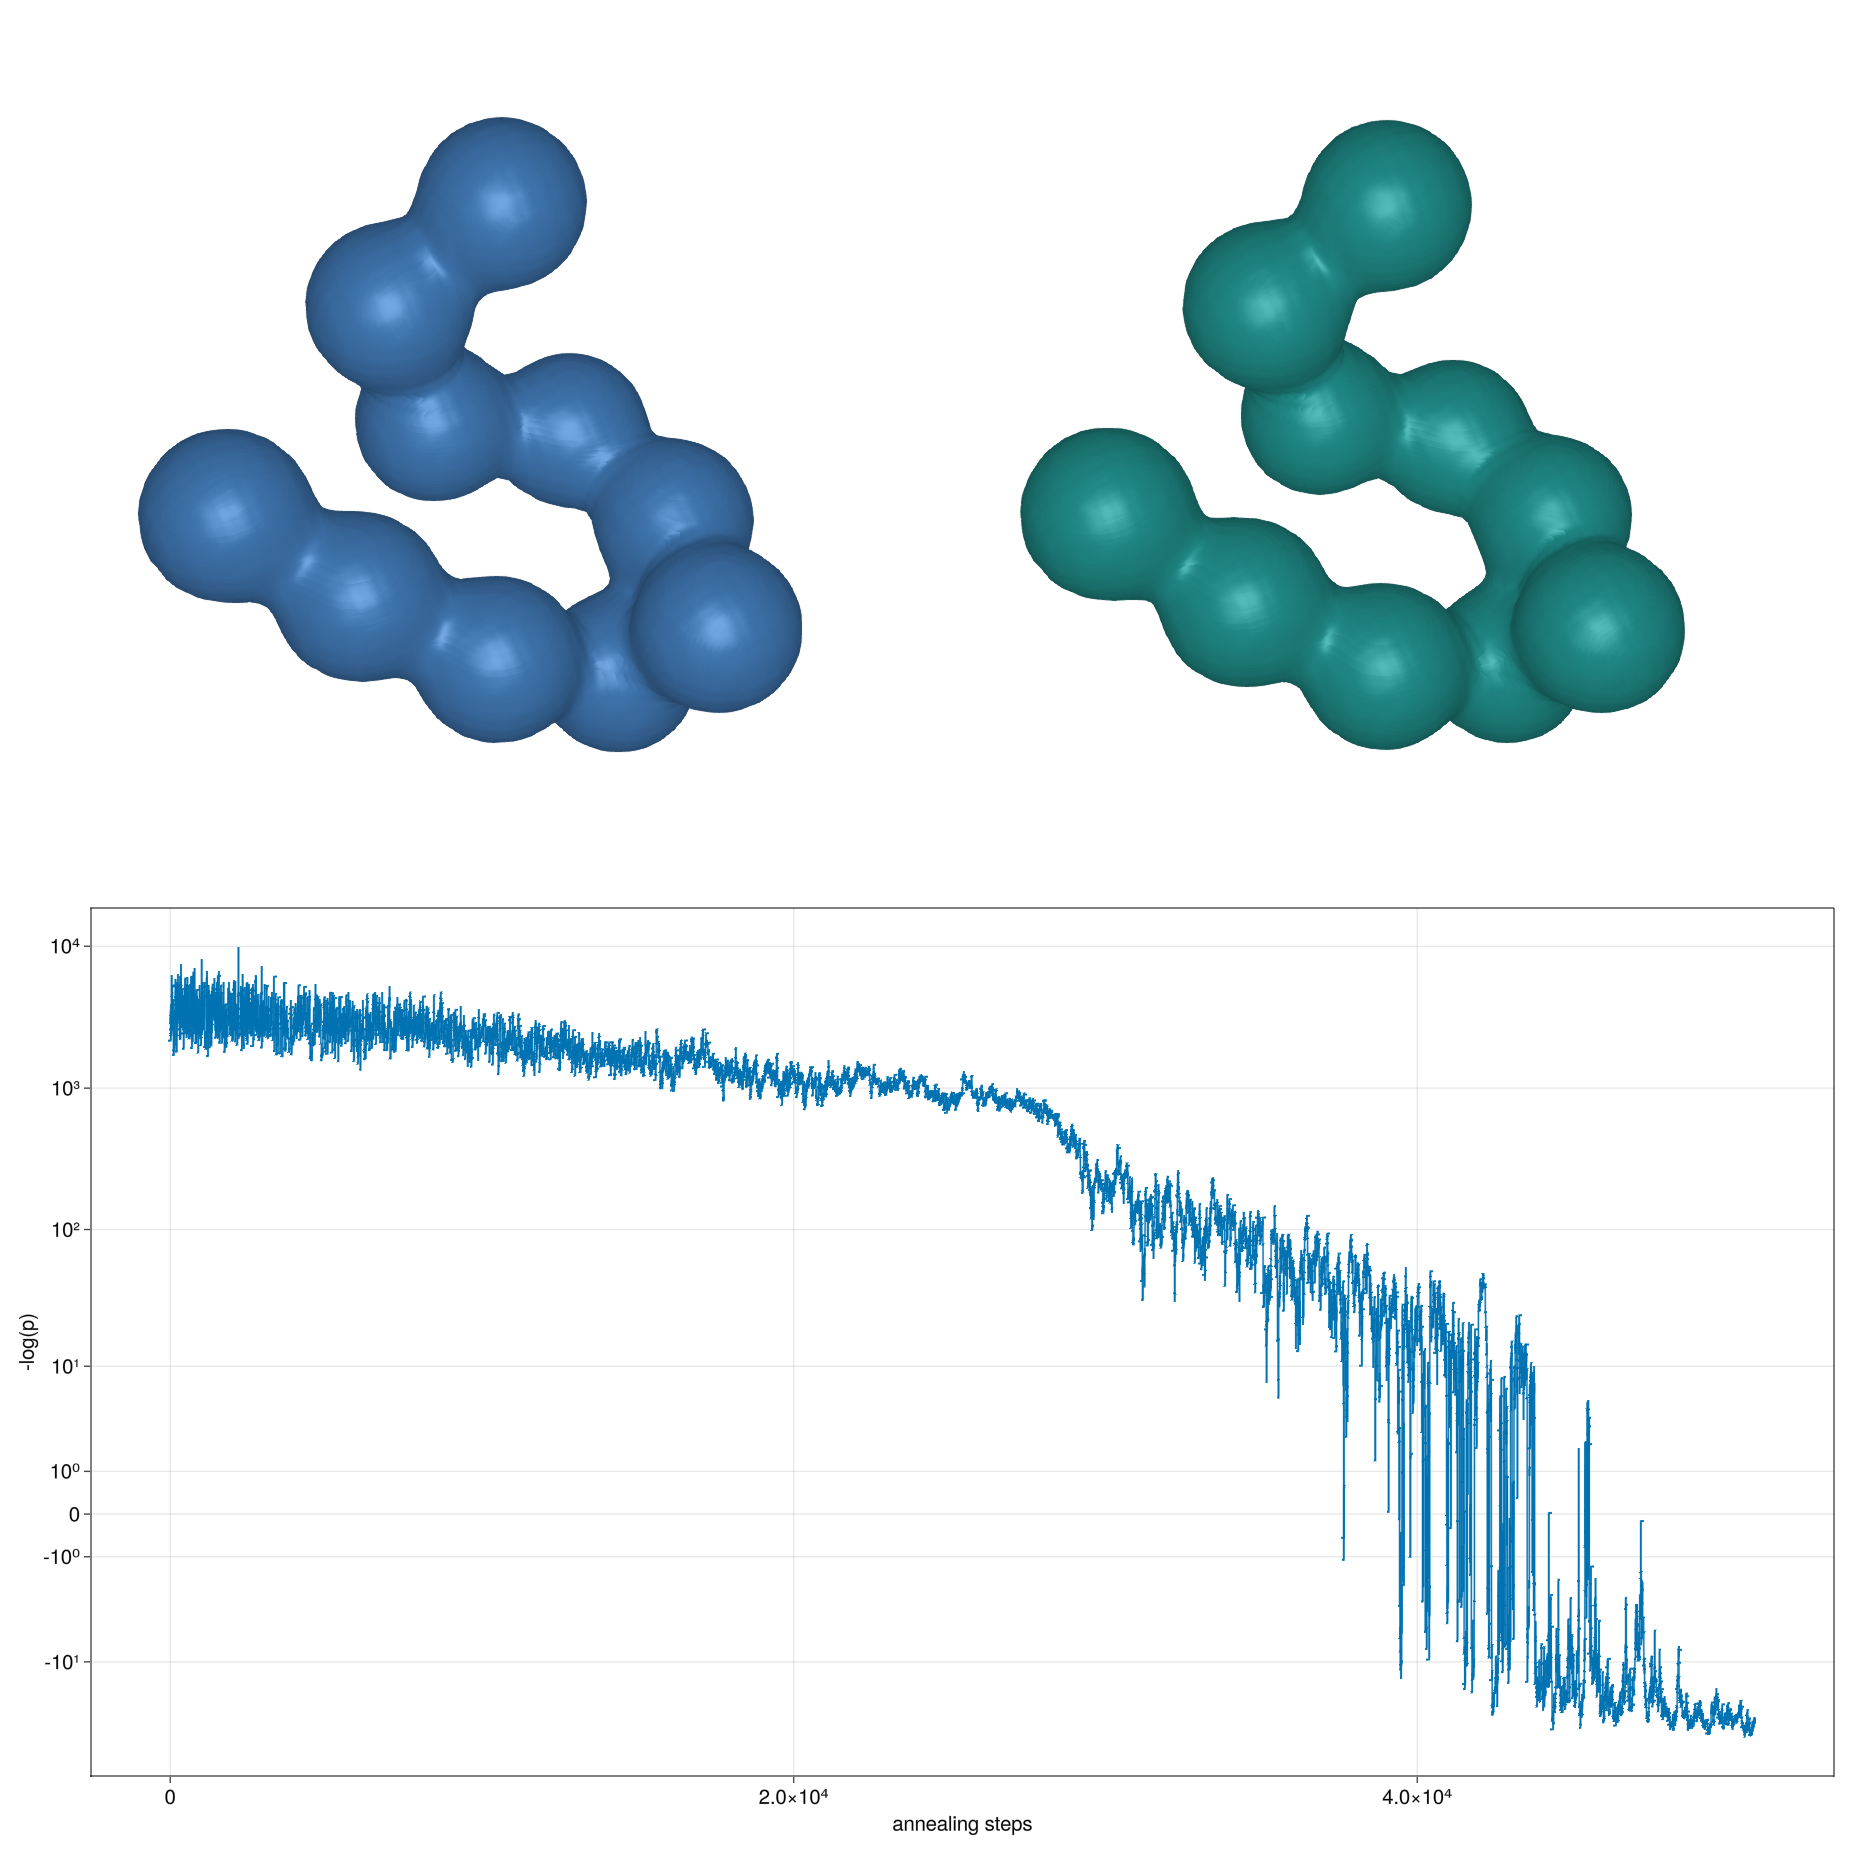

In [29]:
# the output should now look something like this
fig

## FSC resolution

6.80991007146578
0.5665212428063658


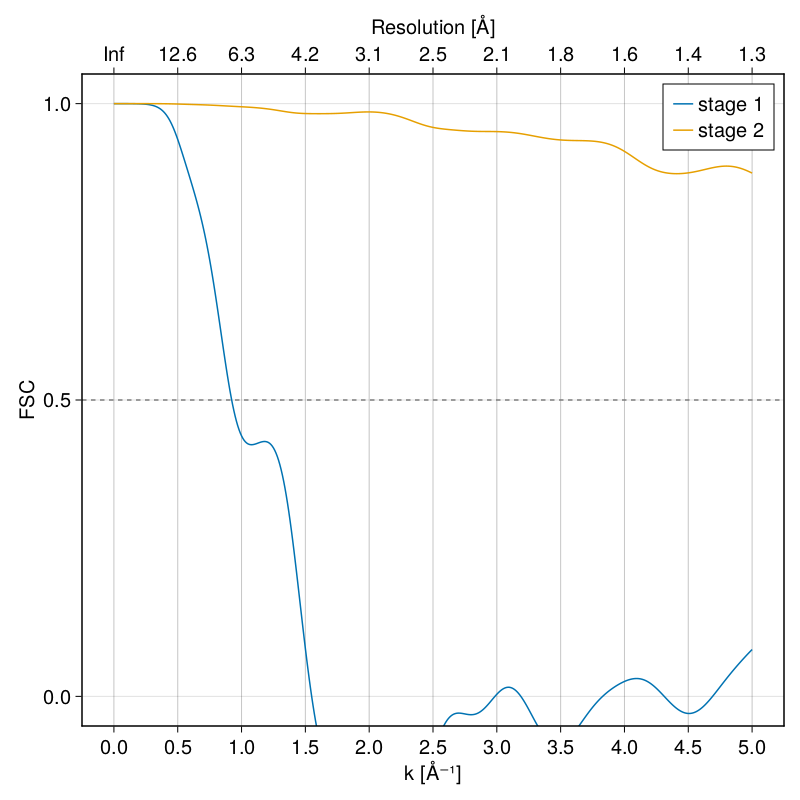

In [30]:
cairo(); fig = Figure(resolution = (800, 800))

ks = 0:0.01:5
ticks = 0:0.5:maximum(ks)

ax1 = Axis(fig[1,1], xlabel = "k [Å⁻¹]", ylabel = "FSC", xticks = ticks)
ax2 = Axis(fig[1,1], xaxisposition = :top, xlabel = "Resolution [Å]",
    xticks = (collect(ticks), string.(round.(2pi./ticks, digits = 1))))
scatter!(ax2, [0, maximum(ks)], [0, 1], color = :transparent)
hideydecorations!(ax2)

hlines!(ax1, [0.5], linestyle = :dash, color = :grey)
ylims!(ax1, -0.05, 1.05)

for (i, s) in enumerate([stage1, stage2])
    aligned = nph.aligned(s.configuration, object, ntries = 20000)
    lines!(ax1, ks, nph.fsc(aligned, object, ks), label = "stage $i")
    println("Achieved resolution in stage $(i): $(round(nph.fscResolution(aligned, object), digits = 2))Å")
end
axislegend(ax1, position = :rt)

fig

# Ensemble

In [659]:
# Create the test ensemble

ps = 4 * [[SA[-2.0, 0, 0], SA[-1.0, 0, 0], SA[0.0, 0, 0], SA[1.0, 0, 0], SA[2.0, 0, 0]], 
      [SA[-2.0, 0, 0], SA[-1.0, 0, 0], SA[0.0, 0, 0], SA[0, 1.0, 0], SA[0.0, 2.0, 0]],
      [SA[-1.0, 0, 1.0], SA[-1.0, 0, 0], SA[-1.0, 1.0, 0], SA[0, 1.0, 0], SA[0.0, 1.0, -1.0]]]
    
structures = 0.01nph.AtomVolume.(ps, 1.0, 10)
weights = [0.2, 0.3, 0.5]
object = (structures, weights);

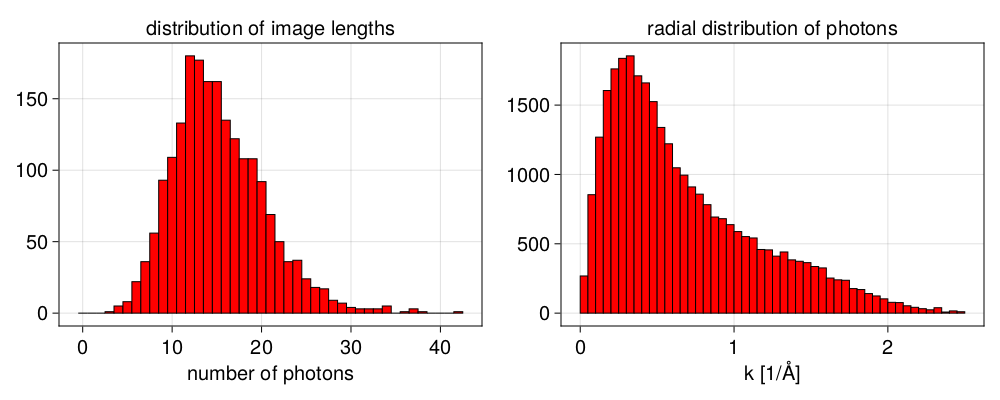

In [660]:
# Generate images

λ = 2.5
N = round(Int, 15 / mean(nph.scatteringProbability.(object[1], λ = λ), Weights(object[2])))

radius = 2.5

gens = nph.imageGenerator.(N, object[1], maxr = radius, wavelength = λ)
images = [sample(gens, Weights(object[2]))() for i in 1:2000]

cairo(); fig = Figure(resolution = (1000, 400)); 
ax1 = Axis(fig[1,1], xlabel = "number of photons", title = "distribution of image lengths", titlefont = :regular); 
hist!(ax1, length.(images), bins=-0.5:maximum(length.(images))+1, color=:red, strokewidth=1, strokecolor=:black)

ax2 = Axis(fig[1,2], xlabel = "k [1/Å]", title = "radial distribution of photons", titlefont = :regular)
rs = 0:0.05:radius
hist!(ax2, norm.(reduce(vcat, images)), bins=0:0.05:radius, color=:red, strokewidth=1, strokecolor=:black)
fig

In [661]:
# Setup computation on gpu. 

params = nph.integrationParameters(qstep = 0.05, qmax = radius, wavelength = λ, precision = 23, npercircle = 32)
logp = nph.logpClosureConf(images, params, N);

In [662]:
# Setup Monte Carlo simulated annealing

objectEnergy = -logp(object) # reference value

lfs = [nph.AtomVolume(1, 2.5) for i in 1:3]
proposers = (
    nph.AdaptiveProposer(nph.GibbsProposer(nph.CombinedProposer(nph.MultiProposer(nph.StructureProposer.(lfs, 0.0)), 
        nph.WidthProposer(0.001)), 1)),
    fill(nph.AdaptiveProposer(nph.GibbsProposer(nph.WeightProposer(Erlang(20, 1 / 3 / 20)), 2), 
            steplambda = 1.001, stepmax = 0.1), 5)...,
)

start = ([0.01nph.randomAtomVolume(5, 1.0, 5) for i in 1:3], normalize(ones(3), 1))

state = nph.Annealer(start, proposers, temperature = 1e2, thalf = 1e4);

In [666]:
# Open a window for realtime visualization during the computation. 
# If this does not work, it can be disabled by removing the argument "output = output_func()" in the next cell

gl()
fig, onode, snode = monitor(object, state, aligndt = Second(5), sortdt = Second(10));

function output_func()
    dt = Millisecond(30)
    t = now() - dt + Second(1)
    function output(state)
        if now() - t > dt
            snode[] = state
            t = now()
        end
        return !ispressed(fig, Keyboard.escape)
    end
end

display(fig); focus()

In [664]:
# Run simulated annealing. Expected runtime 15 minutes (strongly hardware dependent)

targetTemp = 1.0
nsteps = nph.remainingSteps(state, targetTemp = targetTemp) + 1000
nph.anneal!(state, nph.multienergy(logp, offset = objectEnergy), output = output_func(), nsteps = nsteps, minTemp = targetTemp);

Progress: 100%|███████████████████████████| Time: 0:20:21 (18.11 ms/it)
  stepsizes:    [0.055, 0.029, 0.029, 0.029, 0.029, 0.029]
  temperature:  1.0
  nsteps:       67439/67439
  accepted:     [0.23, 0.22, 0.29, 0.31, 0.34, 0.35]
  energy:       -20.01152677787468


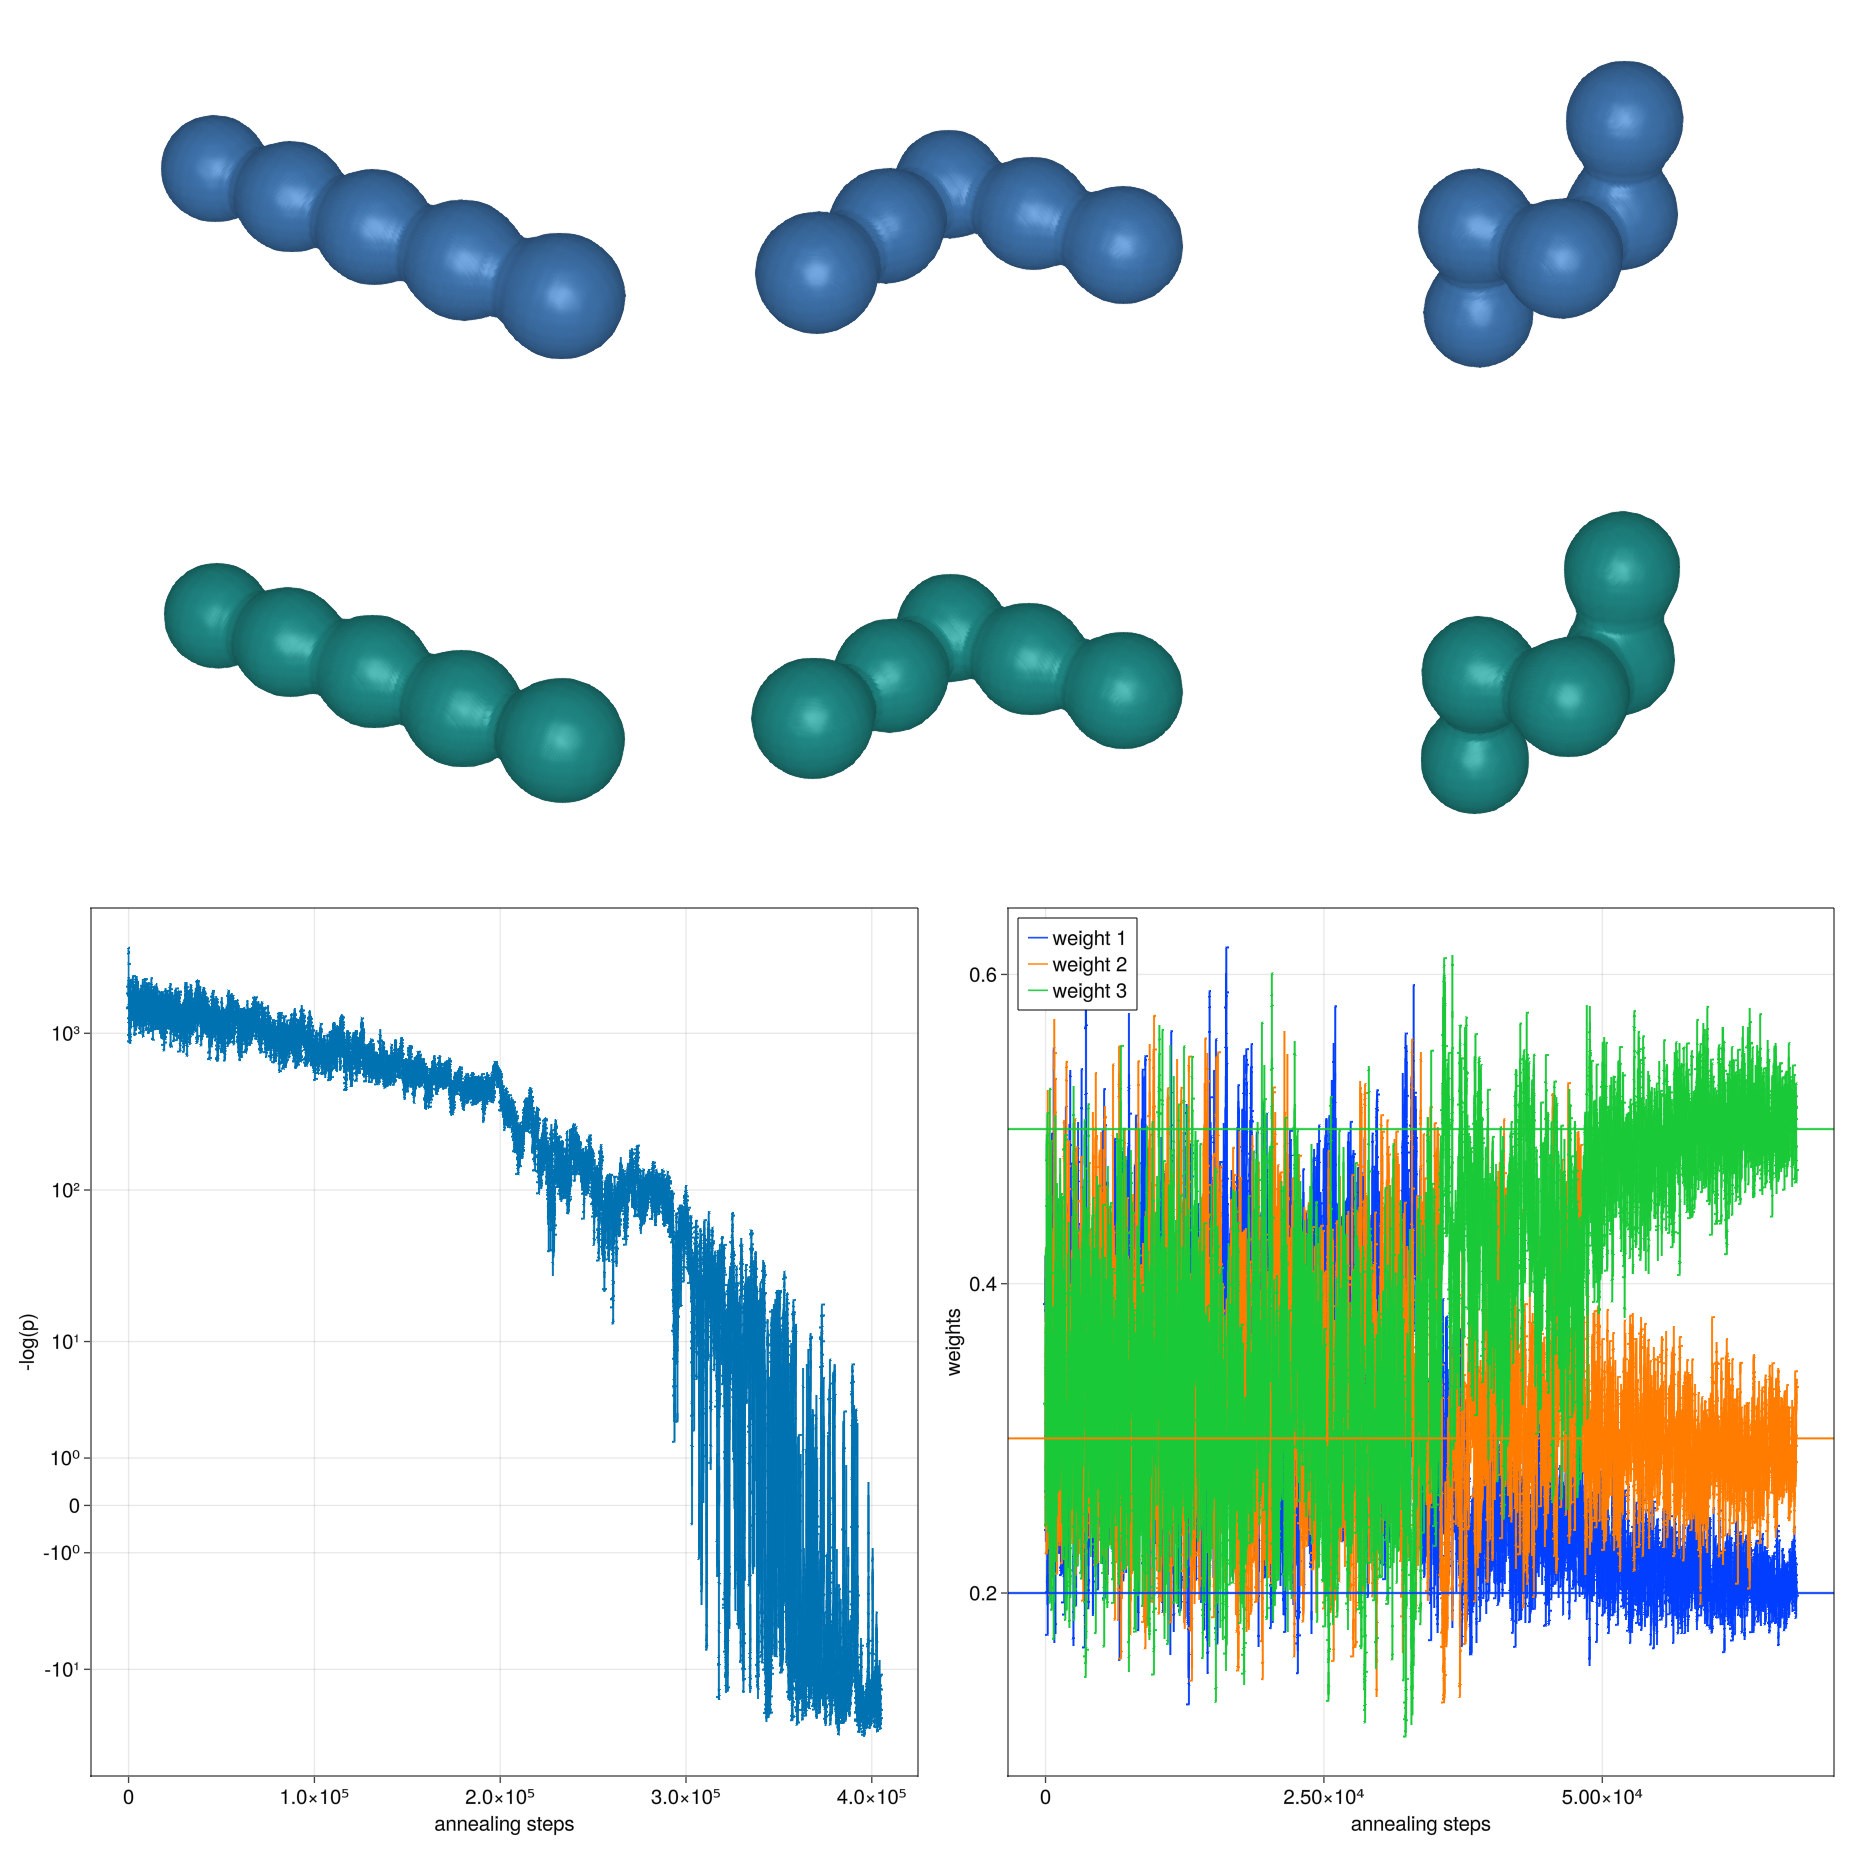

In [668]:
# the output should now look something like this
fig

## FSC resolution

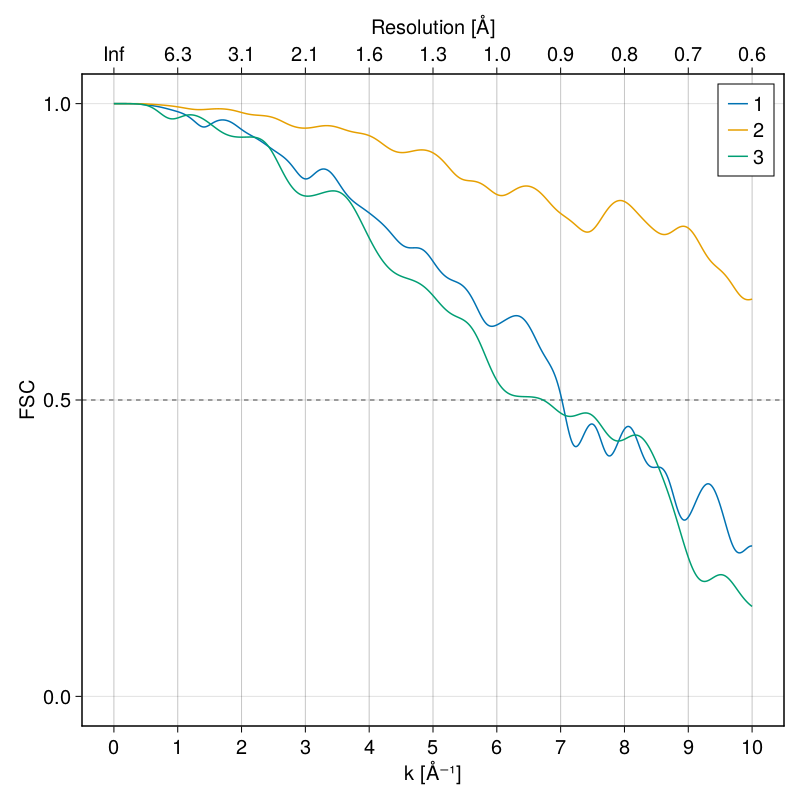

In [669]:
cairo(); fig = Figure(resolution = (800, 800))

ks = 0:0.01:10
ticks = 0:1:maximum(ks)

ax1 = Axis(fig[1,1], xlabel = "k [Å⁻¹]", ylabel = "FSC", xticks = ticks)
ax2 = Axis(fig[1,1], xaxisposition = :top, xlabel = "Resolution [Å]",
    xticks = (collect(ticks), string.(round.(2pi./ticks, digits = 1))))
scatter!(ax2, [0, maximum(ks)], [0, 1], color = :transparent)
hideydecorations!(ax2)

hlines!(ax1, [0.5], linestyle = :dash, color = :grey)
ylims!(ax1, -0.05, 1.05)


# the determined structures are randomly oriented and in a random order. Therefore they need to be sorted and aligned
fs = state.configuration[1]; os = object[1]
al = [nph.aligned(fs[j], os[i], ntries = 2000) for i in 1:length(os), j in 1:length(fs)]
D = [nph.pointCloudDistance(os[i].positions, al[i, j].positions) for i in 1:length(os), j in 1:length(fs)]
perm = hungarian(D)[1]

for i in 1:length(os)
    aligned = nph.aligned(fs[perm[i]], os[i], ntries = 20000)
    lines!(ax1, ks, nph.fsc(aligned, os[i], ks), label = "$i")
end
axislegend(ax1, position = :rt)

fig